### Import of libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading of the file and one of the sheets

In [3]:
# The athletes' names are hiden, and only the initial name and gender are visible through the naming of each dataset

Athletes = {'F_f': '',
            'J_f': '',
            'F_m': '',
            'G_m': '',
            'V_f': '',
            'A_m': '',
            'I_f': ''
            }

# Importing the data to the Athletes dictionary
for i in Athletes:
    Athletes[i] = pd.read_excel('DataFatigInd.xlsx', sheet_name = i)
    Athletes[i]['U.A. Intensidade (ontem)'] =  Athletes[i]['U.A. Intensidade'].shift(1)
    Athletes[i]['Diferença Peso'] = Athletes[i]['Peso basal'].diff()
    Athletes[i]['Diferença Pulso'] = Athletes[i]['Pulso após 2 horas'] - Athletes[i]['Pulso basal']
    Athletes[i].rename(columns={'Data': 'Date',
                                'Nr dia': 'NrDay',
                                'Qualidade de Sono': 'QSleep',
                                'Horas de Cama': 'TSleep',
                                'Apetite': 'Appetite',
                                'Estado de Ânimo': 'StSpirit',
                                'Percepção Carga': 'pEffort',
                                'Pulso após 2 horas': 'ATHr',
                                'Pulso basal': 'Hr',
                                'U.A. Intensidade': 'uaI',
                                'ÍNDICE DE FADIGA': 'FatigInd',
                                'Peso basal': 'Wt',
                                'U.A. Intensidade (ontem)': 'uaI(-1)',
                                'Diferença Peso': 'DeltaWt',
                                'Diferença Pulso': 'DeltaHrtwo'
                                }, inplace=True)
    Athletes[i]["Name"] = i
    Athletes[i]["Sex_F"] = 1 if i[-1] == "f" else 0
df = pd.concat(Athletes.values(), ignore_index=True)


# ###############################
#  df = pd.get_dummies(df, columns=['nivel'])
#  TEMOS DE FAZER ISSO PARA VAR CATEGORICAS, TP estado de espirito, apetite, qualidade de sono, ...
# ###############################

df.head(5)

,Date,NrDay,QSleep,TSleep,Appetite,StSpirit,pEffort,ATHr,Hr,uaI,FatigInd,Wt,uaI(-1),DeltaWt,DeltaHrtwo,Name,Sex_F
0,2019-10-18,2,4.0,7.50,6.0,4.0,6.0,80.0,78.0,1.76,99.809325,60500.0,NaN,NaN,2.0,F_f,1
1,2019-10-19,3,2.0,9.00,7.0,7.0,7.0,72.0,78.0,1.66,87.095325,60500.0,1.76,0.0,-6.0,F_f,1
2,2019-10-20,4,1.0,9.75,7.0,3.0,4.0,72.0,66.0,1.42,50.660225,60500.0,1.66,0.0,6.0,F_f,1
3,2019-10-21,5,2.0,7.50,5.0,3.0,4.0,72.0,72.0,2.03,64.996625,60500.0,1.42,0.0,0.0,F_f,1
4,2019-10-22,6,3.0,8.00,6.0,3.0,6.0,66.0,72.0,1.62,57.985725,61100.0,2.03,600.0,-6.0,F_f,1


O mais interessante é saber a classificação da fadiga para determinar o peso do treino e não o valor, logo devemos fazer intervalos. Seguindo as indicaçãos do expert aka treinador:

5 fatigue classifications:

- *Risk*: Danger! Must rest. Risk of injury or pathological fatigue.

- *Caution*: Caution! If it repeats over several days, reduce the load.

- *Optimal*: Optimal workload.

- *Low*: Low load zone. For recovery purposes only.

- *Minimal*: Excessively low load. Ineffective work.

In [4]:
def fatigue_class(fatigue):
    if fatigue > 90:
        return "Risk"
    elif fatigue > 80:
        return "Caution"
    elif fatigue >= 40:
        return "Optimal"
    elif fatigue > 10:
        return "Low"
    else:
        return "Minimal"
    
df["FatigInd"] = df["FatigInd"].apply(fatigue_class)

In [5]:
# Brief description of the data
df.info()#.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1272 non-null   datetime64[ns]
 1   NrDay       1272 non-null   int64         
 2   QSleep      1185 non-null   float64       
 3   TSleep      1185 non-null   float64       
 4   Appetite    1183 non-null   float64       
 5   StSpirit    1183 non-null   float64       
 6   pEffort     1183 non-null   float64       
 7   ATHr        1183 non-null   float64       
 8   Hr          1186 non-null   float64       
 9   uaI         1255 non-null   float64       
 10  FatigInd    1272 non-null   object        
 11  Wt          1215 non-null   float64       
 12  uaI(-1)     1248 non-null   float64       
 13  DeltaWt     1201 non-null   float64       
 14  DeltaHrtwo  1171 non-null   float64       
 15  Name        1272 non-null   object        
 16  Sex_F       1272 non-nul

In [6]:
df.isna().sum()

Date            0
NrDay           0
QSleep         87
TSleep         87
Appetite       89
StSpirit       89
pEffort        89
ATHr           89
Hr             86
uaI            17
FatigInd        0
Wt             57
uaI(-1)        24
DeltaWt        71
DeltaHrtwo    101
Name            0
Sex_F           0
dtype: int64

In [7]:
df.isnull().sum()

Date            0
NrDay           0
QSleep         87
TSleep         87
Appetite       89
StSpirit       89
pEffort        89
ATHr           89
Hr             86
uaI            17
FatigInd        0
Wt             57
uaI(-1)        24
DeltaWt        71
DeltaHrtwo    101
Name            0
Sex_F           0
dtype: int64

### Description of the variables

- se calhar basta meter a segunda coluna pra frente?

| Variables             | Simplified variable | Description                                                   | Scale     | Apagar (Hugo) | 
| --------------------- | ------------------- | ------------------------------------------------------------- | --------- |---------------|
|                       | All scales go from lowest (best feeling) to highest (worse feeling)                 |           |
| Data                  | Date                | Date of the measure (**?**)                                   | Ordinal   | Não
| Nr do dia             | NrDay               | Key corresponding to the day of the calendar                  | Ordinal   | Sim
| Qualidade do sono     | QSleep              | Perception of how well one slept                              | 2 - 10    | pode-se fazer escala Qual. * Horas
| Horas de cama         | TSleep              | Number of hours slept, monitored by personal smartwatch       | n.a.      | (ver acima)
| Apetite               | Appetite            | Measure of appetite throughout the day                        | 2 - 10    | Não
| Estado de ânimo       | StSpirit            | State of spirit, motivation                                   | 2 - 10    | Não
| Percepção de carga    | pEffort             | Perceived effort from the workout                             | 2 - 10    | Não
| Pulso após 2 hr       | ATHr                | Heart rate two hours after the workout                        | 2 - 10    | já temos o DeltaHrtwo, ns
| ~~Diferença pulso 2 hr~~  | ~~DeltaHrtwo~~  |  ~~Difference between ATHr and AvgHr (athlete specific)~~     | 2 - 10    | Sim
| Diferença pulso 2 hr  | DeltaHrtwo          | *vou fazer a diferenca entre o Hr e o ATHr*                   | 2 - 10    | Não
| Pulso basal           | Hr                  | Average of the heart rate throughout the season               | n.a.      | já temos o DeltaHrtwo, ns
| ~~Diferença pulso basal~~ | ~~DeltaHrb~~    | ~~Difference between Hr and AvgHR (athlete specific)~~        | 2 - 10    | Sim
| U. A. Intensidade     | uaI                 | Measured intensity from each workout (calculated w/ weights)  | 1 - 5     | Não
| ~~Índica de Fadiga~~  | ~~FatigInd~~        | ~~Calculated fatigue index from the variables above~~         | 0 - 100   | Sim
| Índica de Fadiga      | FatigInd            | *Calculada tendo por base o sentimento do atleta e medições do treinador* | 0 - 100   | Não
| ~~Peso basal~~        | ~~Wt~~              | ~~Average of the weight throught the season, weighted daily~~ |           | Sim
| Peso basal            | Wt                  | *Daily weight*                                                |           | já temos a variação do peso, ns
| ~~Diferença peso~~    | ~~DeltaWt~~         | ~~Difference between Wt and basal weight (athlete specific)~~ |           | Sim
| Diferença peso        | DeltaWt | *vou fazer a diferenca de peso entre dois dias consecutivos, será semelhante* |       | Não
| U. A. Intensidade (ontem) | uaI(-1)         | uaI from the day before                                       | 1 - 5     | Não
|                       | Name                | *nome do atleta*                                              |           | Não
|                       | Sex                 | *sexo do atleta*                                              |           | Não

## NaN

apos analisar as variaveis e os valores em falta, chegou-se a conclusao que o melhor seria remover obs com valores em falta

In [8]:
rows_before = len(df)

df.dropna(inplace=True)

rows_after = len(df)

print(f"Number of rows lost: {rows_before - rows_after}")


Number of rows lost: 112


In [9]:
df.isna().sum() + df.isnull().sum()

Date          0
NrDay         0
QSleep        0
TSleep        0
Appetite      0
StSpirit      0
pEffort       0
ATHr          0
Hr            0
uaI           0
FatigInd      0
Wt            0
uaI(-1)       0
DeltaWt       0
DeltaHrtwo    0
Name          0
Sex_F         0
dtype: int64

## dataset analysis pt.2 

ver qnt de tipos de fadiga

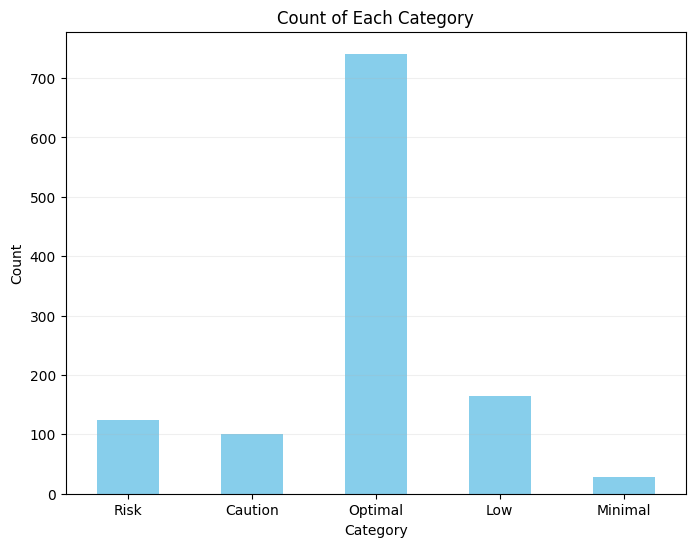

In [10]:
contagem = df["FatigInd"].value_counts()
contagem = contagem.reindex(["Risk", "Caution", "Optimal", "Low", "Minimal"])
contagem.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.2)
plt.xticks(rotation=0)
plt.show()

como temos demasiados ótimos, isto pode enviesar os resultados, ent é melhor apagarmos alguns do optimal e talvez do low. até ficar ao mesmo nivel do Risk. a diferenca entre risk e caution será insiginificante, e o minimal por ser um valor muito extremo pode ficar assim, ig

sao selecionadas ate ao limite, as primeiras de cada classe, pq as primeiras obs sao referentes aos atletas com maior qualidade de dados, digo eu, ou com mais importancia, se n pode se mudar "head" para "sample"

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_5924/2979857564.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('FatigInd', group_keys=False).apply(lambda group: group.head(min(len(group), limite)))#.reset_index(drop=True)


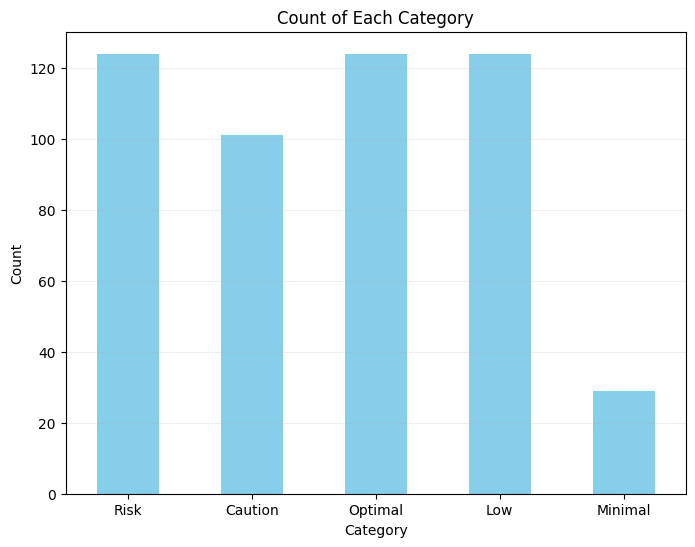

In [11]:
limite = contagem["Risk"]
df_limited = df.groupby('FatigInd', group_keys=False).apply(lambda group: group.head(min(len(group), limite)))#.reset_index(drop=True)

contagem = df_limited["FatigInd"].value_counts()
contagem = contagem.reindex(["Risk", "Caution", "Optimal", "Low", "Minimal"])
contagem.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.2)
plt.xticks(rotation=0)
plt.show()

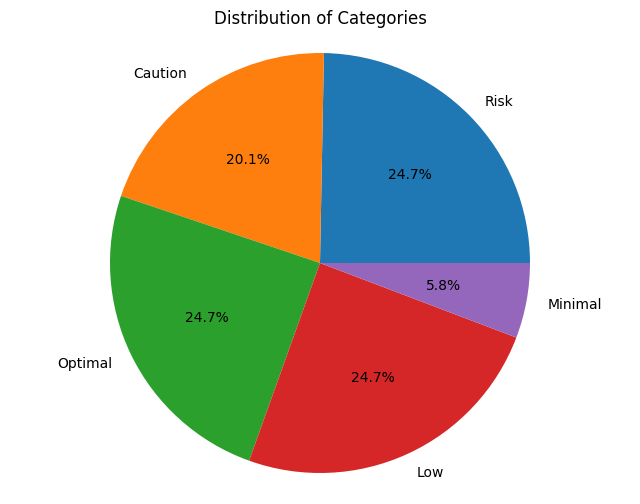

In [12]:
contagem = df_limited["FatigInd"].value_counts()
contagem = contagem.reindex(["Risk", "Caution", "Optimal", "Low", "Minimal"])

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [13]:
print(f"Rows after: {len(df_limited)}")
df_limited.head(3)

Rows after: 502


,Date,NrDay,QSleep,TSleep,Appetite,StSpirit,pEffort,ATHr,Hr,uaI,FatigInd,Wt,uaI(-1),DeltaWt,DeltaHrtwo,Name,Sex_F
1,2019-10-19,3,2.0,9.0,7.0,7.0,7.0,72.0,78.0,1.66,Caution,60500.0,1.76,0.0,-6.0,F_f,1
13,2019-10-31,15,3.0,7.5,6.0,3.0,5.0,72.0,78.0,2.02,Caution,60800.0,2.19,100.0,-6.0,F_f,1
27,2019-11-14,29,4.0,8.0,6.0,4.0,5.0,72.0,78.0,2.12,Caution,60800.0,2.32,300.0,-6.0,F_f,1


## Análise bivariada (relações entre variáveis)

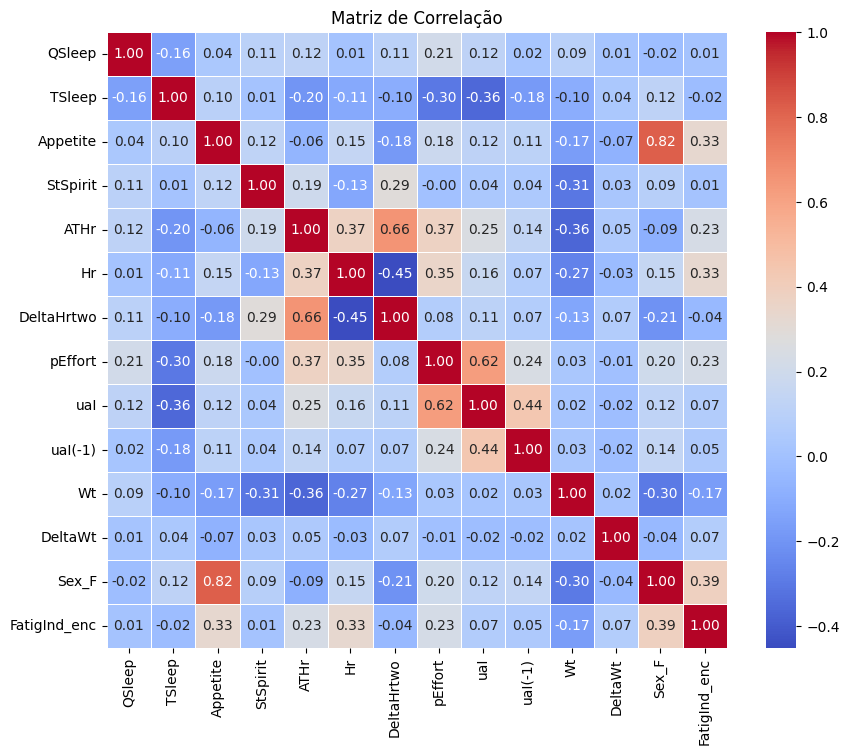

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Exemplo de DataFrame (substitua com seu próprio dataset)
# df = pd.read_csv('seu_arquivo.csv')
df_corr = df_limited.copy()
df_corr = df_corr[['QSleep', 'TSleep', 'Appetite', 'StSpirit', 
                    'ATHr', 'Hr', 'DeltaHrtwo', 'pEffort', 'uaI', 'uaI(-1)',
                    'Wt',  'DeltaWt', 'Sex_F', 'FatigInd']]
       
# Codificar a variável target (se ela for categórica)
# Suponha que 'target' seja a variável categórica
encoder = LabelEncoder()
df_corr['FatigInd_enc'] = encoder.fit_transform(df_corr['FatigInd'])

# Selecione apenas as variáveis numéricas para calcular a correlação
df_numeric = df_corr.select_dtypes(include=['float64', 'int64'])

# Adicione a variável target codificada para análise de correlação
df_numeric['FatigInd_enc'] = df_corr['FatigInd_enc']

# Calcular a matriz de correlação
corr_matrix = df_numeric.corr()

# Plotando o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()


---
---
---

In [15]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


df.dropna(inplace=True)
X = df[['QSleep', 'TSleep', 'Appetite', 'StSpirit', 'pEffort',
       'uaI', 'DeltaWt',
       'DeltaHrtwo', 'Sex_F']]
y = df["FatigInd"]

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 6: Predict using the trained model
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')


Accuracy: 0.6580459770114943
Confusion Matrix:
[[  0   0   0  28   1]
 [  0  11   0  41   1]
 [  0   2   5   2   0]
 [  0   6   2 212   3]
 [  0   0   0  33   1]]
Classification Report:
              precision    recall  f1-score   support

     Caution       0.00      0.00      0.00        29
         Low       0.58      0.21      0.31        53
     Minimal       0.71      0.56      0.62         9
     Optimal       0.67      0.95      0.79       223
        Risk       0.17      0.03      0.05        34

    accuracy                           0.66       348
   macro avg       0.43      0.35      0.35       348
weighted avg       0.55      0.66      0.57       348



/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Step 8: Check the model weights (coefficients)
coefficients = model.coef_
intercept = model.intercept_

# Print the weights for each feature
print(f'Intercept: {intercept}')
for feature, coef in zip(X.columns, coefficients[0]):
    print(f'{feature}: {coef}')


Intercept: [ 0.23201025  0.56511967 -3.63749427  2.62649315  0.21387121]
QSleep: 0.4018563935757308
TSleep: -0.2472772958247808
Appetite: 0.04443851825648031
StSpirit: -0.011340719732305582
pEffort: 0.7510695912349657
uaI: 0.42914020174635137
DeltaWt: -0.14547366098338152
DeltaHrtwo: 0.17850646169803466
Sex_F: 0.338096760301514
